# Project 3. E.coli outbreak investigation. De novo assembly and annotation of bacterial genomes.

Lab notebook by Nikita Vyatkin

This week, you will follow in the footsteps of the bioinformaticians investigating the outbreak by assembling the genome of the deadly E. coli X strain. Specifically, we will provide you with Illumina reads from the TY2482 sample, which were generated at Beijing Genome Institute and deposited into the Short Read Archive (http://www.ncbi.nlm.nih.gov/sra) for public access. After we have assembled the E. coli X genome, we will determine which other strain(s) it is most similar to in an effort to determine how it could have arisen. In particular, once we know where it came from, we can ask what new genes it possesses for pathogenicity, and how it evolved these new functions.

Our workflow will be to answer the following questions:
1. What is the genome sequence of E. coli X?
2. What strain of E. coli is E. coli X most similar to? (Where did it come from?)
3. What are the genes that E. coli X contains?
4. Which of these genes make E. coli X distinct?
5. How did E. coli X evolve to obtain these genes?
6. How did E. coli X become pathogenic?





## Assembling the Genome

DNA sequencing technology cannot read whole genomes in one go, so we will assemble genome from the short reads generated by the Illumina instrument. We will use the [SPAdes](https://cab.spbu.ru/software/spades/) assembler (Bankevich et al., 2012) to assemble the E. coli X genome from reads into contigs.

A contig is a “contiguous” segment of the genome that has been reconstructed by an assembly algorithm. In addition to contigs, SPAdes uses information about the distances between reads within read-pairs (called insert size) to combine contigs into ordered collections of adjacent contigs called scaffolds.Genome assembly programs often fill a gap in a scaffold of length m by a sequence of m occurrences of “N” (a placeholder for unknown nucleotides).

In modern DNA sequencing projects, DNA fragments are sequenced from both the 5' and 3' ends, giving rise to paired reads separated by some insert size. The forward and reverse read in a paired read are generated from the forward and reverse strand, respectively. A collection of paired reads is called a sequencing library; whereas most paired libraries generate reads with insert sizes below 1 kb, libraries with longer (2 kb-10 kb) insert sizes are called mate-pairs.

Many sequencing projects generate several libraries of paired reads with different insert sizes; for example, the sequencing project at the center of this task employs three libraries of insert lengths 270, 2000, and 6000 nucleotides.

The advantage of using multiple libraries is that libraries with small insert sizes are better suited for resolving short repeats, whereas libraries with larger insert sizes are better suited for resolving long repeats. For example, all bacterial genomes contain ribosomal operons, which are often repeated more than six times and are approximately 5000 nucleotides long. Thus, to resolve ribosomal operons, we need mate-pair libraries with insert sizes exceeding 5000 nt.

Once we have sequenced a genome, there are many metrics for assessing the resulting assembly. We will use QUAST (Gurevich et al., 2013), which takes many metrics into account to evaluate the overall quality of an assembly.

One of the common metrics is the N50 statistic. N50 is defined as the maximal contig length for which all contigs greater than or equal to that length comprise at least half of the sum of the lengths of all the contigs. For example, consider the five toy contigs with the following lengths: [10, 20, 30, 60, 70]. Here, the total length of contigs is 190, and contigs of length 60 and 70 account for at least 50% of the total length of contigs (60 + 70 = 130), but the contig of length 70 does not account for 50% of the total length of contigs. Thus, N50 is equal to 60.

## Dataset

For this project, we provide three libraries from the TY2482 sample with the following
insert sizes and orientation:
* SRR292678 - paired end, insert size 470 bp ([forward reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz), [reverse reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz), 400 Mb each)
* SRR292862 - mate pair, insert size 2 kb, ([forward reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R1_001.fastq.gz), [reverse reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R2_001.fastq.gz), 200 Mb each)
* SRR292770 - mate pair, insert size 6 kb, ([forward reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R1_001.fastq.gz), [reverse reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R2_001.fastq.gz), 200 Mb each)

In [4]:
! mkdir raw_data

In [7]:
! wget -P raw_data https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R1_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R2_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R1_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R2_001.fastq.gz

--2022-11-21 18:03:20--  https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 13.33.244.215, 13.33.244.96, 13.33.244.69, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|13.33.244.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 425982530 (406M) [application/x-gzip]
Saving to: ‘raw_data/SRR292678sub_S1_L001_R1_001.fastq.gz’

SRR292678sub_S1_L00 100%[===================>] 406,25M  3,62MB/s    in 2m 1s   

2022-11-21 18:05:21 (3,37 MB/s) - ‘raw_data/SRR292678sub_S1_L001_R1_001.fastq.gz’ saved [425982530/425982530]

--2022-11-21 18:05:21--  https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz
Reusing existing connection to d28rh4a8wq0iu5.cloudfront.net:443.
HTTP request sent, awaiting response... 200 OK
Length: 426246191 (406M) [application/x-gzip]
Saving to: ‘raw_data/SRR292678sub_S1_L001_R2_001.

In [9]:
! gunzip raw_data/*

### Simple manual data analysis

In [4]:
out = ! wc -l raw_data/*.fastq

out = [s.split() for s in out]

for item in out:
    print(f"Number of reads in {item[1]}: {int(item[0]) // 4:,}")

Number of reads in raw_data/SRR292678sub_S1_L001_R1_001.fastq: 5,499,346
Number of reads in raw_data/SRR292678sub_S1_L001_R2_001.fastq: 5,499,346
Number of reads in raw_data/SRR292770_S1_L001_R1_001.fastq: 5,102,041
Number of reads in raw_data/SRR292770_S1_L001_R2_001.fastq: 5,102,041
Number of reads in raw_data/SRR292862_S2_L001_R1_001.fastq: 5,102,041
Number of reads in raw_data/SRR292862_S2_L001_R2_001.fastq: 5,102,041
Number of reads in total: 31,406,856


In [12]:
! mkdir fastqc_reports

In [19]:
! fastqc -q -t 6 -o fastqc_reports/ raw_data/*

## K-mer profile and genome size estimation

For our purposes it’s OK to only analyze the paired-end library (SRR292678). To count kmers, we can use the Jellyfish - fast kmer counting program that will count the frequency of all possible k-mers of a given length in our data (available with apt-get).

In [11]:
! jellyfish count --help

Usage: jellyfish count [options] file:path+

Count k-mers in fasta or fastq files

Options (default value in (), *required):
 -m, --mer-len=uint32                    *Length of mer
 -s, --size=uint64                       *Initial hash size
 -t, --threads=uint32                     Number of threads (1)
     --sam=PATH                           SAM/BAM/CRAM formatted input file
 -F, --Files=uint32                       Number files open simultaneously (1)
 -g, --generator=path                     File of commands generating fast[aq]
 -G, --Generators=uint32                  Number of generators run simultaneously (1)
 -S, --shell=string                       Shell used to run generator commands ($SHELL or /bin/sh)
 -o, --output=string                      Output file (mer_counts.jf)
 -c, --counter-len=Length in bits         Length bits of counting field (7)
     --out-counter-len=Length in bytes    Length in bytes of counter field in output (4)
 -C, --canonical                         

In [12]:
! mkdir jellyfish_analysis

In [116]:
! jellyfish count -t 10 -C -s 50000000 -m 15 -o jellyfish_analysis/kmer_counts_15.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq
! jellyfish count -t 10 -C -s 50000000 -m 20 -o jellyfish_analysis/kmer_counts_20.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq
! jellyfish count -t 10 -C -s 50000000 -m 25 -o jellyfish_analysis/kmer_counts_25.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq
! jellyfish count -t 10 -C -s 50000000 -m 30 -o jellyfish_analysis/kmer_counts_30.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq
! jellyfish count -t 10 -C -s 50000000 -m 35 -o jellyfish_analysis/kmer_counts_35.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq
! jellyfish count -t 10 -C -s 50000000 -m 40 -o jellyfish_analysis/kmer_counts_40.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq

In [117]:
! jellyfish histo --help

Usage: jellyfish histo [options] db:path

Create an histogram of k-mer occurrences

Create an histogram with the number of k-mers having a given
count. In bucket 'i' are tallied the k-mers which have a count 'c'
satisfying 'low+i*inc <= c < low+(i+1)*inc'. Buckets in the output are
labeled by the low end point (low+i*inc).

The last bucket in the output behaves as a catchall: it tallies all
k-mers with a count greater or equal to the low end point of this
bucket.

Options (default value in (), *required):
 -l, --low=uint64                         Low count value of histogram (1)
 -h, --high=uint64                        High count value of histogram (10000)
 -i, --increment=uint64                   Increment value for buckets (1)
 -t, --threads=uint32                     Number of threads (1)
 -f, --full                               Full histo. Don't skip count 0. (false)
 -o, --output=string                      Output file
 -v, --verbose                            Output information

In [118]:
! jellyfish histo -t 10 -h 100000 -o jellyfish_analysis/plot_15.csv jellyfish_analysis/kmer_counts_15.jf
! jellyfish histo -t 10 -o jellyfish_analysis/plot_20.csv jellyfish_analysis/kmer_counts_20.jf
! jellyfish histo -t 10 -o jellyfish_analysis/plot_25.csv jellyfish_analysis/kmer_counts_25.jf
! jellyfish histo -t 10 -o jellyfish_analysis/plot_30.csv jellyfish_analysis/kmer_counts_30.jf
! jellyfish histo -t 10 -o jellyfish_analysis/plot_35.csv jellyfish_analysis/kmer_counts_35.jf
! jellyfish histo -t 10 -o jellyfish_analysis/plot_40.csv jellyfish_analysis/kmer_counts_40.jf

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = {}
for i in np.arange(15, 45, 5):
    df[i] = pd.read_csv(f"jellyfish_analysis/plot_{i}.csv", sep=' ', names=["occur_num", f"num_{i}-mers"])
    df[i].index = df[i]["occur_num"]
    df[i].drop(columns=["occur_num"], inplace=True)

dfs = pd.concat(df.values(), axis=1)
dfs.sort_values("occur_num", inplace=True)
dfs

,num_15-mers,num_20-mers,num_25-mers,num_30-mers,num_35-mers,num_40-mers
occur_num,,,,,,
1,8848757.0,11299614.0,12709831.0,13731726.0,14423186.0,14835478.0
2,823288.0,788314.0,819226.0,824157.0,810607.0,785506.0
3,162952.0,154045.0,156898.0,155536.0,151445.0,145326.0
4,54647.0,52812.0,53681.0,53295.0,52088.0,50888.0
5,24150.0,24787.0,25923.0,26443.0,26265.0,25743.0
...,...,...,...,...,...,...
7731,1.0,NaN,NaN,NaN,NaN,NaN
8438,1.0,NaN,NaN,NaN,NaN,NaN
8476,1.0,NaN,NaN,NaN,NaN,NaN


In [120]:
df[30]["log_num_30-mers"] = np.log(df[30]["num_30-mers"]) 

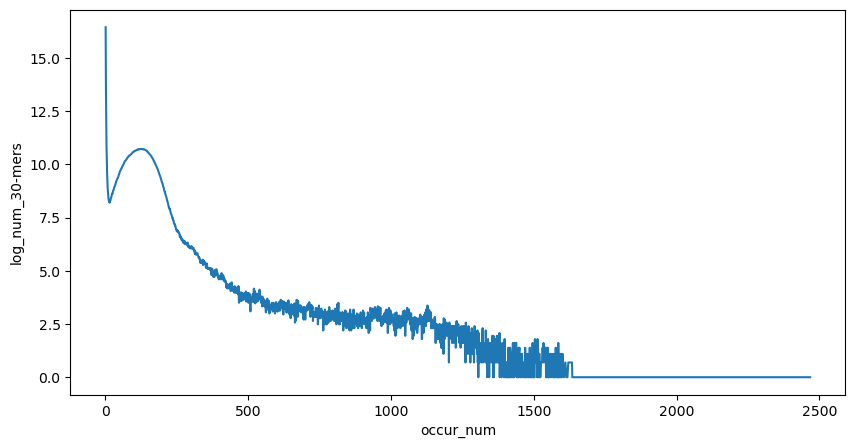

In [121]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df[30], x="occur_num", y="log_num_30-mers")

plt.show()

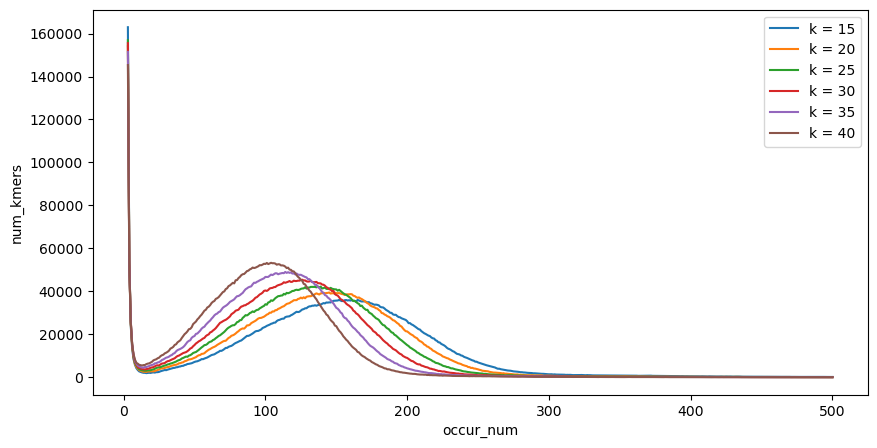

In [122]:
plt.figure(figsize=(10, 5))
for i in np.arange(15, 45, 5):
    sns.lineplot(data=df[i].loc[3:500], x="occur_num", y=f"num_{i}-mers", label=f"k = {i}")

plt.ylabel("num_kmers")
plt.show()

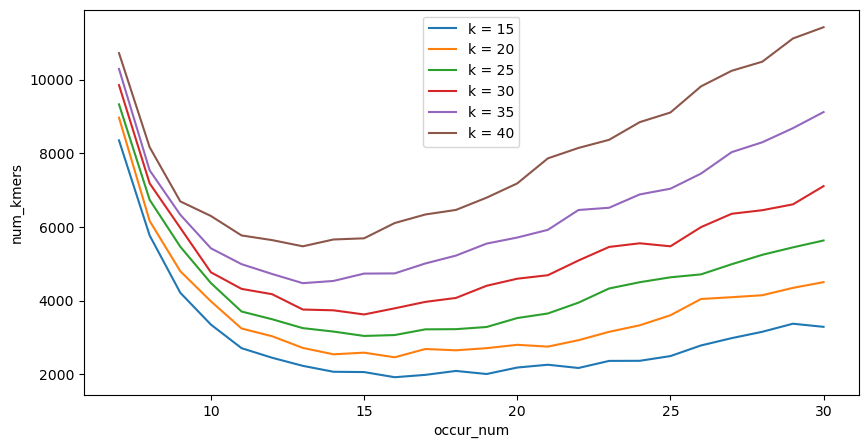

In [135]:
plt.figure(figsize=(10, 5))
for i in np.arange(15, 45, 5):
    sns.lineplot(data=df[i].loc[7:30], x="occur_num", y=f"num_{i}-mers", label=f"k = {i}")

plt.ylabel("num_kmers")
plt.show()